# Coherent Time Averaging Signal Loss Test

**Josh Dillon 5/16/22**

This notebook performs the final power spectrum analysis for the Validation test of averaging coherently in LST before forming power spectra. It compares power spectra of just a simulated EoR using ~21 second integrations and compares them to power spectra of the same field computed after averaging coherently for ~210 seconds. 

In [1]:
import hera_pspec as hp
import numpy as np
from utils import load_red_uvps, red_avg
import matplotlib.pyplot as plt
import copy
import scipy
%matplotlib inline

In [2]:
# Import power spectrum without extra time-averaging
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/eor_only/all_epochs/pspec/pspec.grp1.of1.true_eor.K.h5", keep_open=False)
uvps_eor_K, lens, angs, Nblps = load_red_uvps(psc, 'stokespol')

In [3]:
# Import power spectrum with extra time-averaging
psc = hp.PSpecContainer("/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/eor_only/all_epochs/pspec/pspec.grp1.of1.true_eor.TK.h5", keep_open=False)
uvps_eor_TK, lens, angs, Nblps  = load_red_uvps(psc, 'stokespol')

In [4]:
# set all noise power spectra to unity
for uvps_eor in [uvps_eor_K, uvps_eor_TK]:
    for uvps in uvps_eor:
        for key in uvps.get_all_keys():
            uvps.set_stats('P_N', key, np.ones_like(uvps.get_data(key), dtype=float))

In [5]:
# redundant average
uvp_eor_K_avg = red_avg(uvps_eor_K, exclude_autos=False, exclude_cross=True)
uvp_eor_TK_avg = red_avg(uvps_eor_TK, exclude_autos=False, exclude_cross=True)

In [6]:
# file containing final per-baseline power spectra from the end-to-end validation test
df = '/lustre/aoc/projects/hera/Validation/test-4.1.0/LSTBIN/fg_only/all_epochs_preprocessed/pspec/pspec.grp1.of1.LPXLTK.h5'
# load get pspec container for cross-talk subtracted files
psc = hp.container.PSpecContainer(df, keep_open=False)
uvps_xtk, lens, angs, Nblps = load_red_uvps(psc, 'stokespol', proj_EW_cut=14., spws=[0, 1], polpairs=['pI'])

uvp_xtk_ravg = red_avg(uvps_xtk, exclude_autos=False, exclude_cross=True, error_weights='P_N')

In [7]:
# Generate key map
xtk_blps = uvp_xtk_ravg.get_blpairs()
xtk_vecs = uvp_xtk_ravg.bl_vecs
key_map = {}
for blp, vec in zip(uvp_eor_TK_avg.get_blpairs(), uvp_eor_TK_avg.bl_vecs):
    assert np.min(np.linalg.norm(xtk_vecs[:, :2] - vec[:2], axis=1)) < 1
    closest_blp = xtk_blps[np.argmin(np.linalg.norm(xtk_vecs[:, :2] - vec[:2], axis=1))]
    for i in uvp_eor_TK_avg.spw_array:
        key_map[(i, blp, ('pI', 'pI'))] = (i, closest_blp, ('pI', 'pI'))

In [8]:
# time average
lst_cut = 0, 24

eor_K_lsts = np.unique(uvp_eor_K_avg.lst_avg_array) * 12 / np.pi
eor_TK_lsts = np.unique(uvp_eor_TK_avg.lst_avg_array) * 12 / np.pi

uvp_eor_K_tavg = uvp_eor_K_avg.select(times=np.unique(uvp_eor_K_avg.time_avg_array)[(eor_K_lsts > lst_cut[0]) & (eor_K_lsts<lst_cut[1])], inplace=False)
uvp_eor_TK_tavg = uvp_eor_TK_avg.select(times=np.unique(uvp_eor_TK_avg.time_avg_array)[(eor_TK_lsts > lst_cut[0]) & (eor_TK_lsts<lst_cut[1])], inplace=False)
uvp_eor_K_tavg.average_spectra(time_avg=True, inplace=True, error_weights='P_N')
uvp_eor_TK_tavg.average_spectra(time_avg=True, inplace=True, error_weights='P_N')

In [9]:
# time average end-to-end pspec
lst_indexes = np.unique(uvp_xtk_ravg.lst_1_array, return_index=True)[1]
uvp_xtk_lsts = np.array([uvp_xtk_ravg.lst_avg_array[i] for i in sorted(lst_indexes)])
uvp_xtk_tavg = uvp_xtk_ravg.select(times=np.unique(uvp_xtk_ravg.time_avg_array)[(uvp_xtk_lsts > lst_cut[0]) & (uvp_xtk_lsts < lst_cut[1])], inplace=False)
uvp_xtk_tavg.average_spectra(time_avg=True, inplace=True, error_weights='P_N')

In [10]:
# use key map to set stats to match end-to-end pipeline
for key in uvp_eor_K_tavg.get_all_keys():
    uvp_eor_K_tavg.set_stats('P_N', key, uvp_xtk_tavg.get_stats('P_N', key_map[key]))
    uvp_eor_TK_tavg.set_stats('P_N', key, uvp_xtk_tavg.get_stats('P_N', key_map[key]))    

In [11]:
# Spherical Binning Cuts
wedge_buff_ns = 300
sph_minimum_ew_distance = 15
sph_minimum_bl_length = 0
sph_maximum_bl_length = 1e100

# Spherical Binning Parameters
dk_multiplier = 2.0 # the size of each spherical k bin (Delta k) when multiplied by the natural k_para spacing
k_start_multiplied = .75 # the center of first spherical k bin in units of Delta k

uvp_eor_K_sph_1, uvp_eor_TK_sph_1 = None, None
uvp_eor_K_sph_2, uvp_eor_TK_sph_2 = [], []

# spherical average onto wide LOS k grid
for uvp in [uvp_eor_K_tavg, uvp_eor_TK_tavg]:
    for band in range(2):
        # set dk separately for each band   
        dk = dk_multiplier * np.median(np.diff(uvp.get_kparas(band)))
        kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 

        u = copy.deepcopy(uvp)
        # set P_N for all k_para modes below horizon delay + wedge_buff to large value
        u.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)

        # cut baselines by setting noise to infinity
        for blp, blvec in zip(u.get_blpairs(), u.get_blpair_blvecs()):
            cut = False
            if np.linalg.norm(blvec) < sph_minimum_bl_length:
                cut = True
            if np.linalg.norm(blvec) > sph_maximum_bl_length:
                cut = True
            if np.abs(blvec[0]) < sph_minimum_ew_distance:
                cut = True
            if cut:
                for spw in u.spw_array:
                    for pp in u.get_polpairs():
                        k = (spw, blp, pp)
                        u.set_stats('P_N', k, np.ones_like(u.get_stats('P_N', k)) * np.inf)

        # spherical average
        sph = hp.grouping.spherical_average(u, kbins, dk, error_weights='P_N')
        # append
        if band == 0:
            if uvp == uvp_eor_K_tavg:
                uvp_eor_K_sph_1 = sph
            elif uvp == uvp_eor_TK_tavg:
                uvp_eor_TK_sph_1 = sph
        elif band == 1:
            if uvp == uvp_eor_K_tavg:
                uvp_eor_K_sph_2 = sph
            elif uvp == uvp_eor_TK_tavg:
                uvp_eor_TK_sph_2 = sph                        

/users/jsdillon/lustre/tmp/ipykernel_28303/1350960226.py:38: RuntimeWarning: invalid value encountered in multiply
  u.set_stats('P_N', k, np.ones_like(u.get_stats('P_N', k)) * np.inf)


/users/jsdillon/lustre/tmp/ipykernel_28303/4157386059.py:10: RuntimeWarning: invalid value encountered in true_divide
  p1, = ax.plot(kbins, uvp_eor_TK_sph.get_data(key).real[0] / uvp_eor_K_sph.get_data(key).real[0], lw=2, label=f'Band {band + 1}')


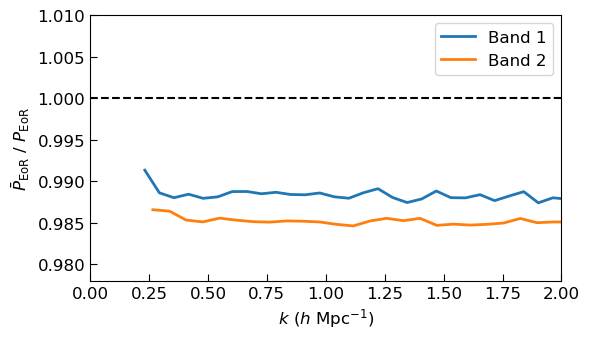

In [12]:
# plot results
fig, ax = plt.subplots(1, 1, figsize=(6,3.5), dpi=100)

ax.tick_params(labelsize=12, direction='in', size=5)
for band in range(2):
    uvp_eor_TK_sph = [uvp_eor_TK_sph_1, uvp_eor_TK_sph_2][band]
    uvp_eor_K_sph = [uvp_eor_K_sph_1, uvp_eor_K_sph_2][band]
    kbins = kbins = uvp_eor_K_sph.get_kparas(band)
    key = (band, uvp_eor_K_sph.get_blpairs()[0], 'pI')
    p1, = ax.plot(kbins, uvp_eor_TK_sph.get_data(key).real[0] / uvp_eor_K_sph.get_data(key).real[0], lw=2, label=f'Band {band + 1}')

ax.legend(fontsize=12)
ax.axhline(1, c='k', ls='--')
ax.set_xlim(.0, 2)
ax.set_ylim(0.978, 1.01)
# ax.grid()
ax.set_xlabel(r'$k\ (h\ {\rm Mpc}^{-1})$', fontsize=12)
ax.set_ylabel(r'$\bar{P}_{\rm EoR}\ /\ P_{\rm EoR}$', fontsize=12)
plt.tight_layout()

#fig.savefig("plots/test4_pspec_avg_EoR.pdf", dpi=100, bbox_inches='tight')

In [13]:
# save results for easy plotting elsewhere
uvp_eor_K_sph_1.write_hdf5('uvp_eor_K_sph_1.h5', overwrite=True)
uvp_eor_K_sph_2.write_hdf5('uvp_eor_K_sph_2.h5', overwrite=True)
uvp_eor_TK_sph_1.write_hdf5('uvp_eor_TK_sph_1.h5', overwrite=True)
uvp_eor_TK_sph_2.write_hdf5('uvp_eor_TK_sph_2.h5', overwrite=True)

uvp_eor_K_sph_1.h5 exists, overwriting...
uvp_eor_K_sph_2.h5 exists, overwriting...
uvp_eor_TK_sph_1.h5 exists, overwriting...
uvp_eor_TK_sph_2.h5 exists, overwriting...


## Also perform field-averages of the EoR only to compare to end-to-end results

In [14]:
lstcuts = [(-2.5, 0), # Field A
           (0.75, 2.75), # Field B
           (4, 6.25), # Field C
           (6.25, 9.25), # Field D
           (9.25, 14.75),  # Field E
          ]

In [15]:
# average in lst fields
uvp_xtk_tavg_by_field, uvp_eor_TK_tavg_by_field = [], []
for field, lc in enumerate(lstcuts):
    # weight time-average by P_N
    lst_indexes = np.unique(uvp_xtk_ravg.lst_1_array, return_index=True)[1]
    lsts = np.array([uvp_xtk_ravg.lst_avg_array[i] for i in sorted(lst_indexes)])
    lsts_hrs = np.unwrap(lsts) * 12 / np.pi 
    while np.max(lsts_hrs) > 24:
        lsts_hrs -= 24
    
    lcut = (lsts_hrs >= lc[0]) & (lsts_hrs <= lc[1])
    if not np.any(lcut):
        continue
    
    # select field
    u_xtk = uvp_xtk_ravg.select(lsts=lsts[lcut], inplace=False)
    u_eor = uvp_eor_TK_avg.select(lsts=lsts[lcut], inplace=False)    
    if not np.any(np.isfinite(u_xtk.stats_array['P_N'][0])):
        if not np.any(np.isfinite(u_xtk.stats_array['P_N'][1])):
            continue    

    # Update stats
    for key in u_eor.get_all_keys():
        u_eor.set_stats('P_N', key, u_xtk.get_stats('P_N', key_map[key]))       

    # average in time
    u_xtk.average_spectra(time_avg=True, error_weights='P_N')
    uvp_xtk_tavg_by_field.append(u_xtk)
    u_eor.average_spectra(time_avg=True, error_weights='P_N')
    uvp_eor_TK_tavg_by_field.append(u_eor)

In [16]:
uvp_xtk_dsq_1, uvp_eor_TK_dsq_1 = [], []
uvp_xtk_dsq_2, uvp_eor_TK_dsq_2 = [], []

# spherical average onto wide LOS k grid
# note that only covariance arrays will be reliable, as stats_arrays cannot account for bin2bin correlation
for band in range(2):
    # set dk separately for each band   
    dk = dk_multiplier * np.median(np.diff(uvp_xtk_tavg_by_field[0].get_kparas(band)))
    kbins = np.arange(k_start_multiplied * dk, 2.5, dk) # even spacing 

    for uvp_xtk, uvp_eor in list(zip(uvp_xtk_tavg_by_field, uvp_eor_TK_tavg_by_field)):
        # deepcopy
        u_xtk, u_eor = copy.deepcopy(uvp_xtk), copy.deepcopy(uvp_eor)
        # make a covariance based on norm_cov, scaled by P_N and P_SN if detection is > 2 sigma
#         utils.stat_to_cov(u_xtk, 'P_SN', norm_cov)
        # set P_N for all k_para modes below horizon delay + wedge_buff to large value
        u_xtk.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)
        u_eor.set_stats_slice('P_N', 1e9 / scipy.constants.c, wedge_buff_ns, above=False, val=np.inf)

        # cut baselines by setting noise to infinity
        for u_here in [u_xtk, u_eor]:
            for blp, blvec in zip(u_here.get_blpairs(), u_here.get_blpair_blvecs()):
                cut = False
                if np.linalg.norm(blvec) < sph_minimum_bl_length:
                    cut = True
                if np.linalg.norm(blvec) > sph_maximum_bl_length:
                    cut = True
                if np.abs(blvec[0]) < sph_minimum_ew_distance:
                    cut = True
                if cut:
                    for spw in u_xtk.spw_array:
                        for pp in u_xtk.get_polpairs():
                            k = (spw, blp, pp)
                            u_here.set_stats('P_N', k, np.ones_like(u_here.get_stats('P_N', k)) * np.inf)

        # spherical average
        history = "average weighted by P_N, with {} ns wedge buffer exclusion".format(wedge_buff_ns)
        sph_xtk = hp.grouping.spherical_average(u_xtk, kbins, dk, error_weights='P_N', add_to_history=history)
        sph_eor = hp.grouping.spherical_average(u_eor, kbins, dk, error_weights='P_N', add_to_history=history)

        if band == 0:            
            uvp_xtk_dsq_1.append(sph_xtk.convert_to_deltasq(inplace=False))
            uvp_eor_TK_dsq_1.append(sph_eor.convert_to_deltasq(inplace=False))
        else:
            uvp_xtk_dsq_2.append(sph_xtk.convert_to_deltasq(inplace=False))
            uvp_eor_TK_dsq_2.append(sph_eor.convert_to_deltasq(inplace=False))            

/users/jsdillon/lustre/tmp/ipykernel_28303/3123516150.py:34: RuntimeWarning: invalid value encountered in multiply
  u_here.set_stats('P_N', k, np.ones_like(u_here.get_stats('P_N', k)) * np.inf)


In [24]:
# results are saved to h5 files per-band and per-field
for spw in [0, 1]:
    uvp_eor_TK_dsq = [uvp_eor_TK_dsq_1, uvp_eor_TK_dsq_2][spw]        
    
    for field in range(len(uvp_eor_TK_dsq)):
        # now write Delta sq
        uvp = copy.deepcopy(uvp_eor_TK_dsq[field])
        uvp.select(spws=[spw])
        outfilename = f'EoR_TK_Deltasq_Band_{spw+1}_Field_{"ABCDEFGHIJ"[field]}.h5'
        uvp.write_hdf5(outfilename, overwrite=True)    

EoR_TK_Deltasq_Band_1_Field_A.h5 exists, overwriting...
EoR_TK_Deltasq_Band_1_Field_B.h5 exists, overwriting...
EoR_TK_Deltasq_Band_1_Field_C.h5 exists, overwriting...
EoR_TK_Deltasq_Band_1_Field_D.h5 exists, overwriting...
EoR_TK_Deltasq_Band_1_Field_E.h5 exists, overwriting...
EoR_TK_Deltasq_Band_2_Field_A.h5 exists, overwriting...
EoR_TK_Deltasq_Band_2_Field_B.h5 exists, overwriting...
EoR_TK_Deltasq_Band_2_Field_C.h5 exists, overwriting...
EoR_TK_Deltasq_Band_2_Field_D.h5 exists, overwriting...
EoR_TK_Deltasq_Band_2_Field_E.h5 exists, overwriting...
